<a href="https://colab.research.google.com/github/Dikshuy/jax-MAML/blob/main/sinusoid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import jax.numpy as np
from jax import grad
from jax import vmap # for auto-vectorizing functions
from functools import partial # for use with vmap
from jax import jit # for compiling functions for speedup
from jax import random # for initializing network parameters
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax # neural network layers
import matplotlib.pyplot as plt # visualization
import numpy as onp
from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays 

In [36]:
# Use stax to set up network initialization and evaluation functions
net_init, net_apply = stax.serial(
    Dense(40), Relu,
    Dense(40), Relu,
    Dense(1)
)
in_shape = (-1, 1,)
rng = random.PRNGKey(0)
out_shape, net_params = net_init(rng, in_shape)

In [37]:
def loss(params, inputs, targets):
    # Computes average loss for the batch
    predictions = net_apply(params, inputs)
    return np.mean((targets - predictions)**2)

In [40]:
# batch the inference across K=500
xrange_inputs = np.linspace(-5,5,500).reshape((500, 1)) # (k, 1)
targets = np.sin(xrange_inputs) + onp.random.normal(0,1)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
losses = vmap(partial(loss, net_params))(xrange_inputs, targets) # per-input loss

In [41]:
alpha = .1
def inner_update(p, x1, y1):
    grads = grad(loss)(p, x1, y1)
    inner_sgd_fn = lambda g, state: (state - alpha*g)
    return tree_multimap(inner_sgd_fn, grads, p)

def maml_loss(p, x1, y1, x2, y2):
    p2 = inner_update(p, x1, y1)
    return loss(p2, x2, y2)

In [42]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)  # this LR seems to be better than 1e-2 and 1e-4
out_shape, net_params = net_init(rng,in_shape)
opt_state = opt_init(net_params)

@jit
def step(i, opt_state, x1, y1, x2, y2):
    p = get_params(opt_state)
    g = grad(maml_loss)(p, x1, y1, x2, y2)
    l = maml_loss(p, x1, y1, x2, y2)
    return opt_update(i, g, opt_state), l

K=20

np_maml_loss = []

# Adam optimization
for i in range(20000):
    # define the task
    A = onp.random.uniform(low=0.1, high=.5)
    phase = onp.random.uniform(low=0., high=np.pi)
    noise = onp.random.normal(0,1)
    # meta-training inner split (K examples)
    x1 = onp.random.uniform(low=-5., high=5., size=(K,1))
    y1 = A * onp.sin(x1 + phase) + noise
    # meta-training outer split (1 example). Like cross-validating with respect to one example.
    x2 = onp.random.uniform(low=-5., high=5.)
    y2 = A * onp.sin(x2 + phase) + noise
    opt_state, l = step(i, opt_state, x1, y1, x2, y2)
    np_maml_loss.append(l)

net_params = get_params(opt_state)

/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:201: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)


/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:201: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:201: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:201: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:201: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)


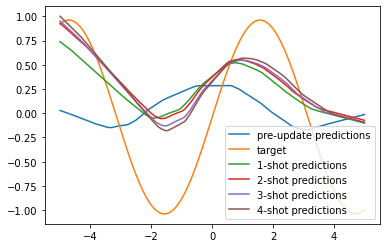

In [43]:
# batch the inference across K=500
targets = np.sin(xrange_inputs) + onp.random.normal(0,1)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
plt.plot(xrange_inputs, predictions, label='pre-update predictions')
plt.plot(xrange_inputs, targets, label='target')

noise = onp.random.normal(0,1,K)
x1 = onp.random.uniform(low=-5., high=5., size=(K,1))
y1 = 1. * onp.sin(x1 + 0.) + noise

for i in range(1,5):
    net_params = inner_update(net_params, x1, y1)
    predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
    plt.plot(xrange_inputs, predictions, label='{}-shot predictions'.format(i))
plt.legend()

In [44]:
def sample_tasks(outer_batch_size, inner_batch_size):
    # Select amplitude and phase for the task
    As = []
    phases = []
    noises = []
    for _ in range(outer_batch_size):        
        As.append(onp.random.uniform(low=0.1, high=.5))
        phases.append(onp.random.uniform(low=0., high=np.pi))
        noises.append(onp.random.normal(0,1))
    def get_batch():
        xs, ys = [], []
        for A, phase, noise in zip(As, phases, noises):
            x = onp.random.uniform(low=-5., high=5., size=(inner_batch_size, 1))
            y = A * onp.sin(x + phase) + noise
            xs.append(x)
            ys.append(y)
        return np.stack(xs), np.stack(ys)
    x1, y1 = get_batch()
    x2, y2 = get_batch()
    return x1, y1, x2, y2

In [45]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)
out_shape, net_params = net_init(rng,in_shape)
opt_state = opt_init(net_params)

# vmapped version of maml loss.
# returns scalar for all tasks.
def batch_maml_loss(p, x1_b, y1_b, x2_b, y2_b):
    task_losses = vmap(partial(maml_loss, p))(x1_b, y1_b, x2_b, y2_b)
    return np.mean(task_losses)

@jit
def step(i, opt_state, x1, y1, x2, y2):
    p = get_params(opt_state)
    g = grad(batch_maml_loss)(p, x1, y1, x2, y2)
    l = batch_maml_loss(p, x1, y1, x2, y2)
    return opt_update(i, g, opt_state), l

np_batched_maml_loss = []
K=20
for i in range(20000):
    x1_b, y1_b, x2_b, y2_b = sample_tasks(4, K)
    opt_state, l = step(i, opt_state, x1_b, y1_b, x2_b, y2_b)
    np_batched_maml_loss.append(l)
    if i % 5000 == 0:
        print(i)
net_params = get_params(opt_state)

/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:201: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:201: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:201: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:201: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:201: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)


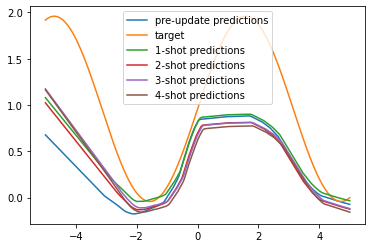

In [49]:
# batch the inference across K=100
targets = np.sin(xrange_inputs) + onp.random.normal(0,1)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
plt.plot(xrange_inputs, predictions, label='pre-update predictions')
plt.plot(xrange_inputs, targets, label='target')

x1 = onp.random.uniform(low=-5., high=5., size=(10,1))
y1 = 1. * onp.sin(x1 + 0.) +  onp.random.normal(0,1,10)

for i in range(1,5):
    net_params = inner_update(net_params, x1, y1)
    predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
    plt.plot(xrange_inputs, predictions, label='{}-shot predictions'.format(i))
plt.legend()

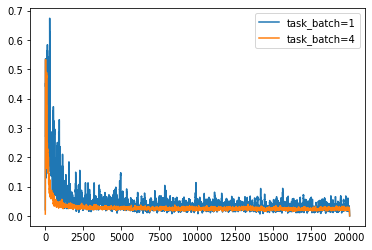

In [47]:
# Comparison of maml_loss for task batch size = 1 vs. task batch size = 8
plt.plot(onp.convolve(np_maml_loss, [.05]*20), label='task_batch=1')
plt.plot(onp.convolve(np_batched_maml_loss, [.05]*20), label='task_batch=4')
# plt.ylim(0., 1e-1)
plt.legend()

In [48]:
np_maml_loss[-1]

DeviceArray(0.0056767, dtype=float32)